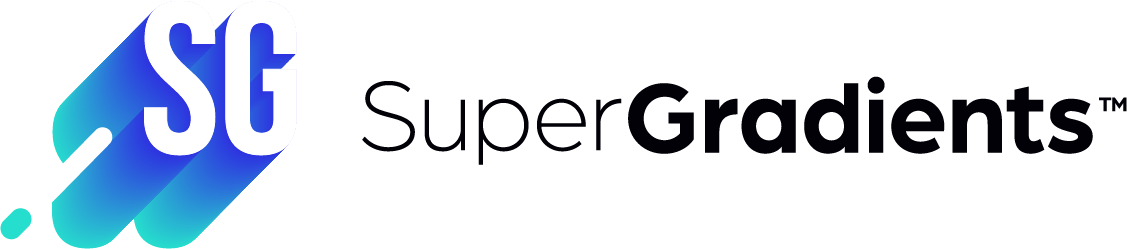

# SuperGradients - Transfer Learning - Classification

In this tutorial we will train and evaluate ResNet18 transfer learning from Imagenet to CIFAR10 for image classification.


The notebook is divided into 7 sections:
1. Experiment setup
2. Dataset definition
3. Architecture definition
4. Training setup
5. Training and Evaluation
6. Predict
7. Convert to ONNX

#Install SG and deci's dependecies


In [1]:
! pip install -qq super-gradients==3.6.0

# 1. Experiment setup

We will first initialize our **trainer** which will be in charge of everything, like training, evaluation, saving checkpoints, plotting etc.

The **experiment name** argument is important as every checkpoints, logs and tensorboards to be saved in a directory with the same name. This directory will be created as a sub-directory of **ckpt_root_dir** as follow:

```
ckpt_root_dir
|─── experiment_name_1
│       ckpt_best.pth                     # Model checkpoint on best epoch
│       ckpt_latest.pth                   # Model checkpoint on last epoch
│       average_model.pth                 # Model checkpoint averaged over epochs
│       events.out.tfevents.1659878383... # Tensorflow artifacts of a specific run
│       log_Aug07_11_52_48.txt            # Trainer logs of a specific run
└─── experiment_name_2
        ...
```

In this notebook multi-gpu training is set as `OFF`, for Distributed training multi_gpu can be set as
 `MultiGPUMode.DISTRIBUTED_DATA_PARALLEL` or `MultiGPUMode.DATA_PARALLEL`.

In [2]:
from super_gradients import Trainer

experiment_name = "classification_transfer_learning"
model_name = "resnet18"

CHECKPOINT_DIR = '/home/notebook_ckpts/'
trainer = Trainer(experiment_name=experiment_name, ckpt_root_dir=CHECKPOINT_DIR)

[2023-10-30 12:28:01] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-10-30 12:28:01] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-10-30 12:28:05] INFO - utils.py - NumExpr defaulting to 2 threads.
[2023-10-30 12:28:10] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-10-30 12:28:10] WARNING - export.py - Failed to import pytorch_quantization
[2023-10-30 12:28:10] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-10-30 12:28:10] WARNING - env_sanity_check.py - Failed to verify installed packages: matplotlib==3.1.3 does not satisfy requirement matplotlib>=3.3.4


# 2. Dataset definition


For the sake of this presentation, We'll use CIFAR10 data set that can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html).

You can see the internal structure and file definition there, too.

We will use `torchvision` dataset implementation from [here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html).

SuperGradients wil handle its download for you.



SG trainer is compatible with torch data loaders so you can use your dataloaders.

## 2.A. Default dataloader from Super Gradients

There is a pool of standard datasets and dataloaders in Super Gradients. It will gracefully handle their creation for you. Now, let's import the dataloaders. Also, they are coming with recipes that include transforms, batch size and everything, so default loading is just as easy as two lines of code.

In [3]:
from super_gradients.training import dataloaders

train_dataloader = dataloaders.get("cifar10_train", dataset_params={}, dataloader_params={"num_workers": 2})
valid_dataloader = dataloaders.get("cifar10_val", dataset_params={}, dataloader_params={"num_workers": 2})

Files already downloaded and verified
Files already downloaded and verified


There are hidden parameters for the datasets and dataloaders, let's show them.


In [4]:
import pprint
print("Dataloader parameters:")
pprint.pprint(train_dataloader.dataloader_params)

print("Dataset parameters:")
pprint.pprint(train_dataloader.dataset.dataset_params)

Let's visualize what we've got there.

We have images and labels, with the default batch size of 256 for training.

In [5]:
from matplotlib import pyplot as plt

def show(images, labels, classes, rows=6, columns=5):
  fig = plt.figure(figsize=(10, 10))

  for i in range(1, columns * rows + 1):
      fig.add_subplot(rows, columns, i)
      plt.imshow(images[i-1].permute(1, 2, 0).clamp(0, 1))
      plt.xticks([])
      plt.yticks([])
      plt.title(f"{classes[labels[i-1]]}")

Dataloader parameters:
{'batch_size': 256,
 'drop_last': False,
 'num_workers': 2,
 'pin_memory': True,
 'shuffle': True}
Dataset parameters:
{'root': './data/cifar10', 'train': True, 'transforms': [{'RandomCrop': {'size': 32, 'padding': 4}}, 'RandomHorizontalFlip', 'ToTensor', {'Normalize': {'mean': [0.4914, 0.4822, 0.4465], 'std': [0.2023, 0.1994, 0.201]}}], 'target_transform': None, 'download': True}
torch.Size([256, 3, 32, 32]) torch.Size([256])


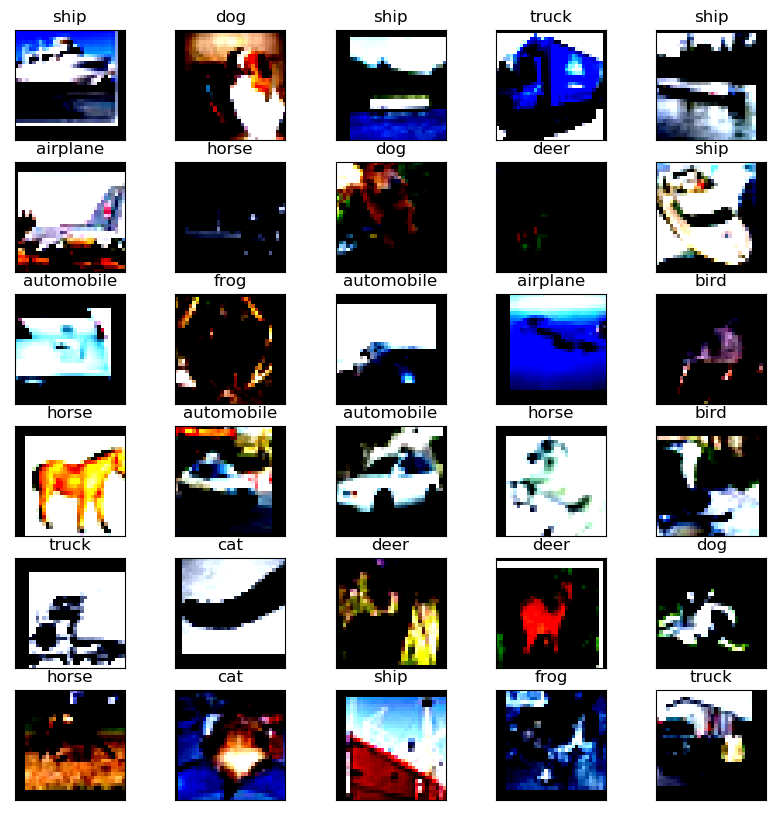

In [6]:
vis_images_train, vis_labels_train = next(iter(train_dataloader))
show(vis_images_train, vis_labels_train, classes=train_dataloader.dataset.classes)

print(vis_images_train.shape, vis_labels_train.shape)

And the default batch 512 for validation.



torch.Size([512, 3, 32, 32]) torch.Size([512])


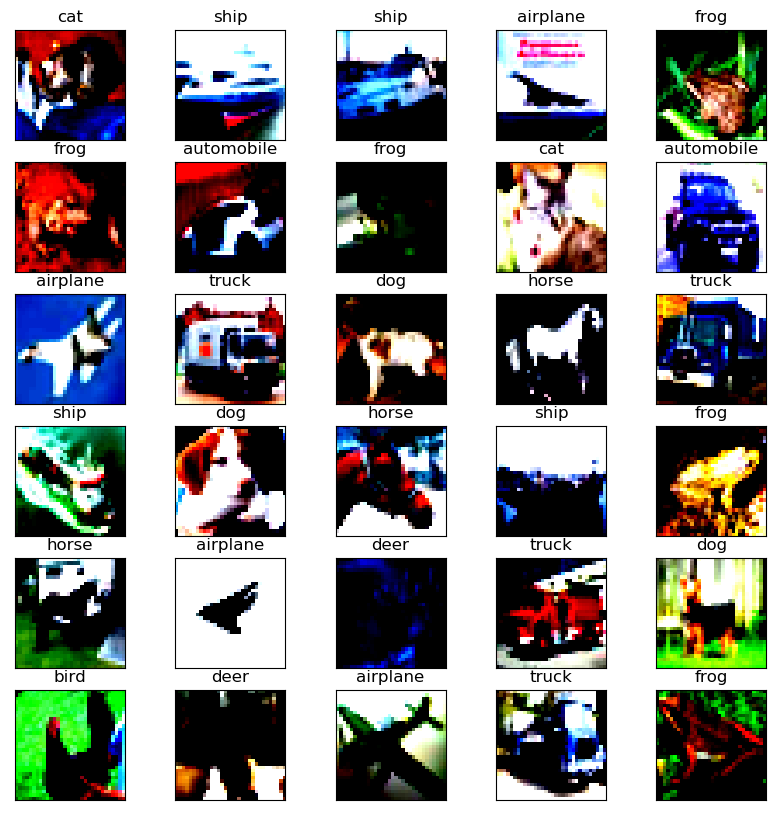

In [7]:
vis_images_val, vis_labels_val = next(iter(valid_dataloader))
show(vis_images_val, vis_labels_val, classes=train_dataloader.dataset.classes)

print(vis_images_val.shape, vis_labels_val.shape)

As you can see, the images are at least normalized, so there is some magic going on. Let's get the control into our hands.

Hidden things are fine but we are going to override some parameters.

## 2.B. Override parameters in dataset and dataloaders creation

We will override transforms that are used in the dataset while using all of the default parameters unchanged.

Files already downloaded and verified


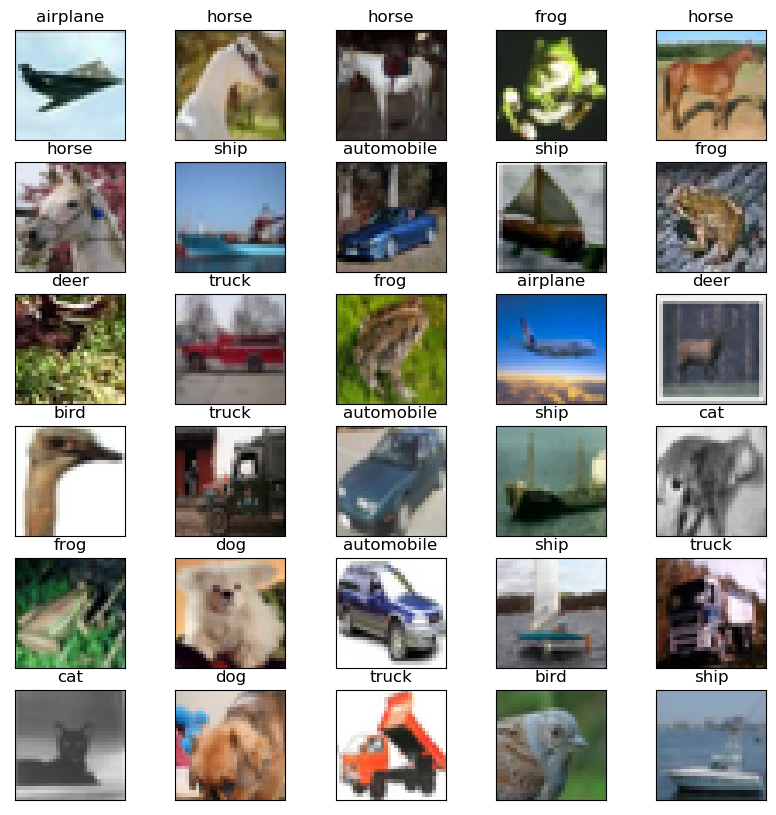

In [8]:
from torchvision import transforms as T
import torch

transforms_vis = [T.ToTensor()] # Let's just do nothing in transforms

vis_dataloader = dataloaders.get("cifar10_train",
                                dataset_params={"transforms": transforms_vis},
                                dataloader_params={"num_workers": 2})

vis_images, vis_labels = next(iter(vis_dataloader))

show(vis_images, vis_labels, classes=train_dataloader.dataset.classes)


# 3. Architecture definition

SG includes implementations of many different architectures for classification tasks.

The architecture that uses here is [ResNet18](https://arxiv.org/abs/1512.03385). We are going to use weights pretrained on the Imagenet dataset as a starting point.

In [9]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

model = models.get(model_name=Models.RESNET18, num_classes=10, pretrained_weights="imagenet")

[2023-10-30 12:28:31] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture resnet18


SG allows you to use one of SG implemented architectures or your custom architecture, which is only an `nn.Module`.

# 4. Training setup


The training parameters for this use case were optimized per dataset and architecture and the type of training (from scratch\transfer learning).
For more recommended training params you can have a look at our recipes [here](https://github.com/Deci-AI/super-gradients/tree/master/src/super_gradients/recipes).

In [10]:
from super_gradients.training import Trainer
from super_gradients.training import training_hyperparams

# you can see more recipes in super_gradients/recipes
training_params =  training_hyperparams.get("training_hyperparams/cifar10_resnet_train_params")


/usr/local/lib/python3.10/dist-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'training_hyperparams/cifar10_resnet_train_params': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


There are a many hidden things going on, let's disclose them:

In [11]:
pprint.pprint("Training parameters")
pprint.pprint(training_params)

We can also override some parameters

In [12]:
training_params["max_epochs"] = 15

# 5. Training and evaluation


The results of the different epochs are kept in your CKPT path.

If you would like to stop and continue the training, you can do it as described here, see `resume` in `training_params`.

In [14]:
trainer.train(model=model,
              training_params=training_params,
              train_loader=train_dataloader,
              valid_loader=valid_dataloader)

[2023-10-30 12:28:39] WARNING - sg_trainer.py - Train dataset size % batch_size != 0 and drop_last=False, this might result in smaller last batch.
[2023-10-30 12:28:39] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231030_122839_316941`
[2023-10-30 12:28:39] INFO - sg_trainer.py - Checkpoints directory: /home/notebook_ckpts/classification_transfer_learning/RUN_20231030_122839_316941


The console stream is now moved to /home/notebook_ckpts/classification_transfer_learning/RUN_20231030_122839_316941/console_Oct30_12_28_39.txt


[2023-10-30 12:28:40] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            50000      (len(train_set))
    - Batch size per GPU:           256        (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             256        (num_gpus * batch_size)
    - Effective Batch size:         256        (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         196        (len(train_loader))
    - Gradient updates per epoch:   196        (len(train_loader) / batch_accumulate)

[2023-10-30 12:28:40] INFO - sg_trainer.py - Started training for 15 epochs (0/14)

Validating: 100%|██████████| 20/20 [00:06<00:00,  3.22it/s]
[2023-10-30 12:29:33] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20231030_122839_316941/ckpt_b

SUMMARY OF EPOCH 0
├── Train
│   ├── CrossEntropyLoss = 2.6516
│   ├── Accuracy = 0.2178
│   └── Top5 = 0.755
└── Validation
    ├── CrossEntropyLoss = 35.9988
    ├── Accuracy = 0.2223
    └── Top5 = 0.6909



Validating epoch 1: 100%|██████████| 20/20 [00:08<00:00,  2.46it/s]
[2023-10-30 12:30:29] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20231030_122839_316941/ckpt_best.pth
[2023-10-30 12:30:29] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.3894999921321869


SUMMARY OF EPOCH 1
├── Train
│   ├── CrossEntropyLoss = 1.9472
│   │   ├── Epoch N-1      = 2.6516 (↘ -0.7044)
│   │   └── Best until now = 2.6516 (↘ -0.7044)
│   ├── Accuracy = 0.2865
│   │   ├── Epoch N-1      = 0.2178 (↗ 0.0687)
│   │   └── Best until now = 0.2178 (↗ 0.0687)
│   └── Top5 = 0.8297
│       ├── Epoch N-1      = 0.755  (↗ 0.0747)
│       └── Best until now = 0.755  (↗ 0.0747)
└── Validation
    ├── CrossEntropyLoss = 1.6419
    │   ├── Epoch N-1      = 35.9988 (↘ -34.3569)
    │   └── Best until now = 35.9988 (↘ -34.3569)
    ├── Accuracy = 0.3895
    │   ├── Epoch N-1      = 0.2223 (↗ 0.1672)
    │   └── Best until now = 0.2223 (↗ 0.1672)
    └── Top5 = 0.8967
        ├── Epoch N-1      = 0.6909 (↗ 0.2058)
        └── Best until now = 0.6909 (↗ 0.2058)



Validating epoch 2: 100%|██████████| 20/20 [00:08<00:00,  2.43it/s]
[2023-10-30 12:31:21] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20231030_122839_316941/ckpt_best.pth
[2023-10-30 12:31:21] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.4431999921798706


SUMMARY OF EPOCH 2
├── Train
│   ├── CrossEntropyLoss = 1.5899
│   │   ├── Epoch N-1      = 1.9472 (↘ -0.3572)
│   │   └── Best until now = 1.9472 (↘ -0.3572)
│   ├── Accuracy = 0.4142
│   │   ├── Epoch N-1      = 0.2865 (↗ 0.1278)
│   │   └── Best until now = 0.2865 (↗ 0.1278)
│   └── Top5 = 0.905
│       ├── Epoch N-1      = 0.8297 (↗ 0.0754)
│       └── Best until now = 0.8297 (↗ 0.0754)
└── Validation
    ├── CrossEntropyLoss = 1.7307
    │   ├── Epoch N-1      = 1.6419 (↗ 0.0888)
    │   └── Best until now = 1.6419 (↗ 0.0888)
    ├── Accuracy = 0.4432
    │   ├── Epoch N-1      = 0.3895 (↗ 0.0537)
    │   └── Best until now = 0.3895 (↗ 0.0537)
    └── Top5 = 0.9243
        ├── Epoch N-1      = 0.8967 (↗ 0.0276)
        └── Best until now = 0.8967 (↗ 0.0276)



Validating epoch 3: 100%|██████████| 20/20 [00:08<00:00,  2.26it/s]
[2023-10-30 12:32:13] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20231030_122839_316941/ckpt_best.pth
[2023-10-30 12:32:13] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.5322999954223633


SUMMARY OF EPOCH 3
├── Train
│   ├── CrossEntropyLoss = 1.4358
│   │   ├── Epoch N-1      = 1.5899 (↘ -0.1541)
│   │   └── Best until now = 1.5899 (↘ -0.1541)
│   ├── Accuracy = 0.4758
│   │   ├── Epoch N-1      = 0.4142 (↗ 0.0616)
│   │   └── Best until now = 0.4142 (↗ 0.0616)
│   └── Top5 = 0.9246
│       ├── Epoch N-1      = 0.905  (↗ 0.0195)
│       └── Best until now = 0.905  (↗ 0.0195)
└── Validation
    ├── CrossEntropyLoss = 1.3059
    │   ├── Epoch N-1      = 1.7307 (↘ -0.4247)
    │   └── Best until now = 1.6419 (↘ -0.3359)
    ├── Accuracy = 0.5323
    │   ├── Epoch N-1      = 0.4432 (↗ 0.0891)
    │   └── Best until now = 0.4432 (↗ 0.0891)
    └── Top5 = 0.9428
        ├── Epoch N-1      = 0.9243 (↗ 0.0185)
        └── Best until now = 0.9243 (↗ 0.0185)



Validating epoch 4: 100%|██████████| 20/20 [00:09<00:00,  2.21it/s]
[2023-10-30 12:33:06] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20231030_122839_316941/ckpt_best.pth
[2023-10-30 12:33:06] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.5981000065803528


SUMMARY OF EPOCH 4
├── Train
│   ├── CrossEntropyLoss = 1.28
│   │   ├── Epoch N-1      = 1.4358 (↘ -0.1558)
│   │   └── Best until now = 1.4358 (↘ -0.1558)
│   ├── Accuracy = 0.5368
│   │   ├── Epoch N-1      = 0.4758 (↗ 0.061)
│   │   └── Best until now = 0.4758 (↗ 0.061)
│   └── Top5 = 0.9469
│       ├── Epoch N-1      = 0.9246 (↗ 0.0223)
│       └── Best until now = 0.9246 (↗ 0.0223)
└── Validation
    ├── CrossEntropyLoss = 1.1333
    │   ├── Epoch N-1      = 1.3059 (↘ -0.1726)
    │   └── Best until now = 1.3059 (↘ -0.1726)
    ├── Accuracy = 0.5981
    │   ├── Epoch N-1      = 0.5323 (↗ 0.0658)
    │   └── Best until now = 0.5323 (↗ 0.0658)
    └── Top5 = 0.9576
        ├── Epoch N-1      = 0.9428 (↗ 0.0148)
        └── Best until now = 0.9428 (↗ 0.0148)



Validating epoch 5: 100%|██████████| 20/20 [00:08<00:00,  2.41it/s]
[2023-10-30 12:33:59] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20231030_122839_316941/ckpt_best.pth
[2023-10-30 12:33:59] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.6258000135421753


SUMMARY OF EPOCH 5
├── Train
│   ├── CrossEntropyLoss = 1.1636
│   │   ├── Epoch N-1      = 1.28   (↘ -0.1164)
│   │   └── Best until now = 1.28   (↘ -0.1164)
│   ├── Accuracy = 0.581
│   │   ├── Epoch N-1      = 0.5368 (↗ 0.0442)
│   │   └── Best until now = 0.5368 (↗ 0.0442)
│   └── Top5 = 0.957
│       ├── Epoch N-1      = 0.9469 (↗ 0.0101)
│       └── Best until now = 0.9469 (↗ 0.0101)
└── Validation
    ├── CrossEntropyLoss = 1.0624
    │   ├── Epoch N-1      = 1.1333 (↘ -0.071)
    │   └── Best until now = 1.1333 (↘ -0.071)
    ├── Accuracy = 0.6258
    │   ├── Epoch N-1      = 0.5981 (↗ 0.0277)
    │   └── Best until now = 0.5981 (↗ 0.0277)
    └── Top5 = 0.9674
        ├── Epoch N-1      = 0.9576 (↗ 0.0098)
        └── Best until now = 0.9576 (↗ 0.0098)



Validating epoch 6: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
[2023-10-30 12:34:53] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20231030_122839_316941/ckpt_best.pth
[2023-10-30 12:34:53] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.6291999816894531


SUMMARY OF EPOCH 6
├── Train
│   ├── CrossEntropyLoss = 1.0738
│   │   ├── Epoch N-1      = 1.1636 (↘ -0.0898)
│   │   └── Best until now = 1.1636 (↘ -0.0898)
│   ├── Accuracy = 0.6156
│   │   ├── Epoch N-1      = 0.581  (↗ 0.0346)
│   │   └── Best until now = 0.581  (↗ 0.0346)
│   └── Top5 = 0.9641
│       ├── Epoch N-1      = 0.957  (↗ 0.0071)
│       └── Best until now = 0.957  (↗ 0.0071)
└── Validation
    ├── CrossEntropyLoss = 1.0479
    │   ├── Epoch N-1      = 1.0624 (↘ -0.0145)
    │   └── Best until now = 1.0624 (↘ -0.0145)
    ├── Accuracy = 0.6292
    │   ├── Epoch N-1      = 0.6258 (↗ 0.0034)
    │   └── Best until now = 0.6258 (↗ 0.0034)
    └── Top5 = 0.9662
        ├── Epoch N-1      = 0.9674 (↘ -0.0012)
        └── Best until now = 0.9674 (↘ -0.0012)



Validating epoch 7: 100%|██████████| 20/20 [00:05<00:00,  3.45it/s]
[2023-10-30 12:35:46] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20231030_122839_316941/ckpt_best.pth
[2023-10-30 12:35:46] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.6668999791145325


SUMMARY OF EPOCH 7
├── Train
│   ├── CrossEntropyLoss = 1.027
│   │   ├── Epoch N-1      = 1.0738 (↘ -0.0468)
│   │   └── Best until now = 1.0738 (↘ -0.0468)
│   ├── Accuracy = 0.6364
│   │   ├── Epoch N-1      = 0.6156 (↗ 0.0208)
│   │   └── Best until now = 0.6156 (↗ 0.0208)
│   └── Top5 = 0.9667
│       ├── Epoch N-1      = 0.9641 (↗ 0.0026)
│       └── Best until now = 0.9641 (↗ 0.0026)
└── Validation
    ├── CrossEntropyLoss = 0.9643
    │   ├── Epoch N-1      = 1.0479 (↘ -0.0836)
    │   └── Best until now = 1.0479 (↘ -0.0836)
    ├── Accuracy = 0.6669
    │   ├── Epoch N-1      = 0.6292 (↗ 0.0377)
    │   └── Best until now = 0.6292 (↗ 0.0377)
    └── Top5 = 0.9684
        ├── Epoch N-1      = 0.9662 (↗ 0.0022)
        └── Best until now = 0.9674 (↗ 0.001)



Validating epoch 8: 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── CrossEntropyLoss = 0.9623
│   │   ├── Epoch N-1      = 1.027  (↘ -0.0647)
│   │   └── Best until now = 1.027  (↘ -0.0647)
│   ├── Accuracy = 0.6579
│   │   ├── Epoch N-1      = 0.6364 (↗ 0.0215)
│   │   └── Best until now = 0.6364 (↗ 0.0215)
│   └── Top5 = 0.9712
│       ├── Epoch N-1      = 0.9667 (↗ 0.0045)
│       └── Best until now = 0.9667 (↗ 0.0045)
└── Validation
    ├── CrossEntropyLoss = 1.0536
    │   ├── Epoch N-1      = 0.9643 (↗ 0.0893)
    │   └── Best until now = 0.9643 (↗ 0.0893)
    ├── Accuracy = 0.6459
    │   ├── Epoch N-1      = 0.6669 (↘ -0.021)
    │   └── Best until now = 0.6669 (↘ -0.021)
    └── Top5 = 0.9703
        ├── Epoch N-1      = 0.9684 (↗ 0.0019)
        └── Best until now = 0.9684 (↗ 0.0019)



Validating epoch 9: 100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── CrossEntropyLoss = 0.9133
│   │   ├── Epoch N-1      = 0.9623 (↘ -0.049)
│   │   └── Best until now = 0.9623 (↘ -0.049)
│   ├── Accuracy = 0.6779
│   │   ├── Epoch N-1      = 0.6579 (↗ 0.02)
│   │   └── Best until now = 0.6579 (↗ 0.02)
│   └── Top5 = 0.9746
│       ├── Epoch N-1      = 0.9712 (↗ 0.0034)
│       └── Best until now = 0.9712 (↗ 0.0034)
└── Validation
    ├── CrossEntropyLoss = 1.0019
    │   ├── Epoch N-1      = 1.0536 (↘ -0.0516)
    │   └── Best until now = 0.9643 (↗ 0.0376)
    ├── Accuracy = 0.658
    │   ├── Epoch N-1      = 0.6459 (↗ 0.0121)
    │   └── Best until now = 0.6669 (↘ -0.0089)
    └── Top5 = 0.9687
        ├── Epoch N-1      = 0.9703 (↘ -0.0016)
        └── Best until now = 0.9703 (↘ -0.0016)



Validating epoch 10: 100%|██████████| 20/20 [00:08<00:00,  2.43it/s]
[2023-10-30 12:38:30] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20231030_122839_316941/ckpt_best.pth
[2023-10-30 12:38:30] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.6798999905586243


SUMMARY OF EPOCH 10
├── Train
│   ├── CrossEntropyLoss = 0.886
│   │   ├── Epoch N-1      = 0.9133 (↘ -0.0273)
│   │   └── Best until now = 0.9133 (↘ -0.0273)
│   ├── Accuracy = 0.6872
│   │   ├── Epoch N-1      = 0.6779 (↗ 0.0093)
│   │   └── Best until now = 0.6779 (↗ 0.0093)
│   └── Top5 = 0.9752
│       ├── Epoch N-1      = 0.9746 (↗ 0.0006)
│       └── Best until now = 0.9746 (↗ 0.0006)
└── Validation
    ├── CrossEntropyLoss = 0.9039
    │   ├── Epoch N-1      = 1.0019 (↘ -0.098)
    │   └── Best until now = 0.9643 (↘ -0.0604)
    ├── Accuracy = 0.6799
    │   ├── Epoch N-1      = 0.658  (↗ 0.0219)
    │   └── Best until now = 0.6669 (↗ 0.013)
    └── Top5 = 0.9749
        ├── Epoch N-1      = 0.9687 (↗ 0.0062)
        └── Best until now = 0.9703 (↗ 0.0046)



Validating epoch 11: 100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── CrossEntropyLoss = 0.8461
│   │   ├── Epoch N-1      = 0.886  (↘ -0.0399)
│   │   └── Best until now = 0.886  (↘ -0.0399)
│   ├── Accuracy = 0.7014
│   │   ├── Epoch N-1      = 0.6872 (↗ 0.0142)
│   │   └── Best until now = 0.6872 (↗ 0.0142)
│   └── Top5 = 0.9773
│       ├── Epoch N-1      = 0.9752 (↗ 0.0022)
│       └── Best until now = 0.9752 (↗ 0.0022)
└── Validation
    ├── CrossEntropyLoss = 1.5331
    │   ├── Epoch N-1      = 0.9039 (↗ 0.6292)
    │   └── Best until now = 0.9039 (↗ 0.6292)
    ├── Accuracy = 0.5342
    │   ├── Epoch N-1      = 0.6799 (↘ -0.1457)
    │   └── Best until now = 0.6799 (↘ -0.1457)
    └── Top5 = 0.9207
        ├── Epoch N-1      = 0.9749 (↘ -0.0542)
        └── Best until now = 0.9749 (↘ -0.0542)



Validating epoch 12: 100%|██████████| 20/20 [00:07<00:00,  2.51it/s]
[2023-10-30 12:40:28] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20231030_122839_316941/ckpt_best.pth
[2023-10-30 12:40:28] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.7125999927520752


SUMMARY OF EPOCH 12
├── Train
│   ├── CrossEntropyLoss = 0.9842
│   │   ├── Epoch N-1      = 0.8461 (↗ 0.1381)
│   │   └── Best until now = 0.8461 (↗ 0.1381)
│   ├── Accuracy = 0.6517
│   │   ├── Epoch N-1      = 0.7014 (↘ -0.0497)
│   │   └── Best until now = 0.7014 (↘ -0.0497)
│   └── Top5 = 0.9671
│       ├── Epoch N-1      = 0.9773 (↘ -0.0102)
│       └── Best until now = 0.9773 (↘ -0.0102)
└── Validation
    ├── CrossEntropyLoss = 0.8281
    │   ├── Epoch N-1      = 1.5331 (↘ -0.705)
    │   └── Best until now = 0.9039 (↘ -0.0758)
    ├── Accuracy = 0.7126
    │   ├── Epoch N-1      = 0.5342 (↗ 0.1784)
    │   └── Best until now = 0.6799 (↗ 0.0327)
    └── Top5 = 0.9789
        ├── Epoch N-1      = 0.9207 (↗ 0.0582)
        └── Best until now = 0.9749 (↗ 0.004)



Validating epoch 13: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]
[2023-10-30 12:41:25] INFO - base_sg_logger.py - Checkpoint saved in /home/notebook_ckpts/classification_transfer_learning/RUN_20231030_122839_316941/ckpt_best.pth
[2023-10-30 12:41:25] INFO - sg_trainer.py - Best checkpoint overriden: validation Accuracy: 0.7336000204086304


SUMMARY OF EPOCH 13
├── Train
│   ├── CrossEntropyLoss = 0.8506
│   │   ├── Epoch N-1      = 0.9842 (↘ -0.1335)
│   │   └── Best until now = 0.8461 (↗ 0.0046)
│   ├── Accuracy = 0.6992
│   │   ├── Epoch N-1      = 0.6517 (↗ 0.0475)
│   │   └── Best until now = 0.7014 (↘ -0.0022)
│   └── Top5 = 0.9774
│       ├── Epoch N-1      = 0.9671 (↗ 0.0103)
│       └── Best until now = 0.9773 (↗ 0.0001)
└── Validation
    ├── CrossEntropyLoss = 0.7855
    │   ├── Epoch N-1      = 0.8281 (↘ -0.0425)
    │   └── Best until now = 0.8281 (↘ -0.0425)
    ├── Accuracy = 0.7336
    │   ├── Epoch N-1      = 0.7126 (↗ 0.021)
    │   └── Best until now = 0.7126 (↗ 0.021)
    └── Top5 = 0.9793
        ├── Epoch N-1      = 0.9789 (↗ 0.0004)
        └── Best until now = 0.9789 (↗ 0.0004)



Validating epoch 14: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── CrossEntropyLoss = 0.802
│   │   ├── Epoch N-1      = 0.8506 (↘ -0.0486)
│   │   └── Best until now = 0.8461 (↘ -0.0441)
│   ├── Accuracy = 0.7183
│   │   ├── Epoch N-1      = 0.6992 (↗ 0.019)
│   │   └── Best until now = 0.7014 (↗ 0.0169)
│   └── Top5 = 0.9804
│       ├── Epoch N-1      = 0.9774 (↗ 0.003)
│       └── Best until now = 0.9774 (↗ 0.003)
└── Validation
    ├── CrossEntropyLoss = 0.7987
    │   ├── Epoch N-1      = 0.7855 (↗ 0.0131)
    │   └── Best until now = 0.7855 (↗ 0.0131)
    ├── Accuracy = 0.725
    │   ├── Epoch N-1      = 0.7336 (↘ -0.0086)
    │   └── Best until now = 0.7336 (↘ -0.0086)
    └── Top5 = 0.9816
        ├── Epoch N-1      = 0.9793 (↗ 0.0023)
        └── Best until now = 0.9793 (↗ 0.0023)



[2023-10-30 12:42:32] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 15:  95%|█████████▌| 19/20 [00:13<00:00,  1.39it/s]

# 6. Predict

As the training was complete you can use the trained model to predict on your data

[2023-10-30 12:56:28] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/notebook_ckpts/classification_transfer_learning/RUN_20231030_122839_316941/ckpt_best.pth checkpoint.
[2023-10-30 12:56:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


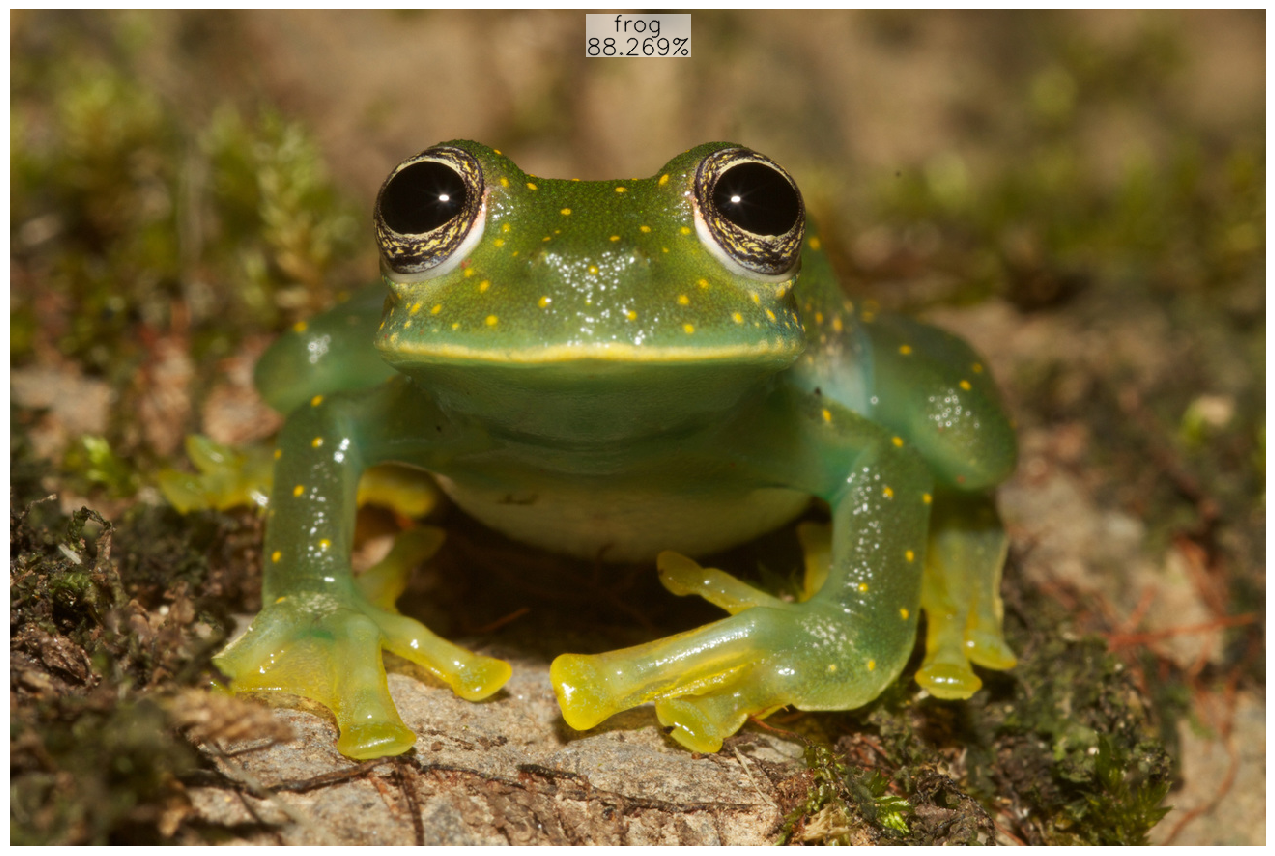

In [21]:
from PIL import Image
import numpy as np
import requests
import os
from super_gradients.training.processing.processing import ComposeProcessing, NormalizeImage, Resize, StandardizeImage, ImagePermute

# Load the best model that we trained
best_model = models.get(Models.RESNET18,
                        num_classes=10,
                        checkpoint_path=os.path.join(trainer.checkpoints_dir_path,"ckpt_best.pth"))
best_model.eval()

image_processor = ComposeProcessing(
    [Resize(size=64), StandardizeImage(),
     NormalizeImage(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]), ImagePermute()]
)

classes = train_dataloader.dataset.classes

best_model.set_dataset_processing_params(image_processor=image_processor, class_names=classes)

prediction = best_model.predict("https://d1jyxxz9imt9yb.cloudfront.net/medialib/3078/image/s1300x1300/IP202207_GlassFrogs_009_365211_reduced.jpg")


prediction.show()

# 7. Convert to ONNX


SG is a Production ready library. All the models implemented in SG can be compiled to ONNX. You can download ONNX file from the files tab.

In [ ]:
import torch
onnx_filename = f"{experiment_name}_{model_name}.onnx"

best_model.eval()
best_model.prep_model_for_conversion(input_size=[1, 3, 32, 32]) # image shape of CIFAR10 images
dummy_input = torch.randn([1, 3, 32, 32], device=next(best_model.parameters()).device)

torch.onnx.export(best_model, dummy_input, onnx_filename)